# Solving Helmholtz equation

In this notebook, we seek to solve

$$ \mathcal{L}_\alpha u = i\alpha u  - L u = f $$

where $\alpha$ is a real-valued constant, $L$ is the grid Laplacian operator, and $u$ is a complex-valued field on the grid. It should be noted that $\alpha = \omega \Delta x^2/\nu$, where $\omega$ is a frequency, $\nu$ is kinematic viscosity, and $\Delta x$ is the grid spacing. The operator $\mathcal{L}_\alpha$ we will call the Helmholtz operator.

In [1]:
using Pkg
pkg"activate /Users/jeff/JuliaProjects/ViscousFlow"
#push!(LOAD_PATH,"/Users/jeff/JuliaProjects/ViscousFlow/src")

Activating environment at `~/JuliaProjects/ViscousFlow/Project.toml`


In [2]:
using Revise

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1240


In [2]:
G = Fields.build_lgf_helmholtz(600,0.016)

┌ Info: Building and caching Helmholtz LGF table for α = 0.016
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:43
┌ Info: Switch to asymptotic formula at i = 148
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:47
┌ Info: Support radius = 351
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


600×600 LinearAlgebra.Symmetric{Complex{Float64},Array{Complex{Float64},2}}:
   0.604608-0.12605im    …  0.0+0.0im  0.0+0.0im  0.0+0.0im
   0.355112-0.123632im      0.0+0.0im  0.0+0.0im  0.0+0.0im
   0.243216-0.119097im      0.0+0.0im  0.0+0.0im  0.0+0.0im
   0.178728-0.11333im       0.0+0.0im  0.0+0.0im  0.0+0.0im
   0.135291-0.106797im      0.0+0.0im  0.0+0.0im  0.0+0.0im
   0.103446-0.0998128im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0790089-0.0926061im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0597712-0.0853494im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0444092-0.0781732im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0320514-0.0711767im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0220851-0.0644339im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0140571-0.0579992im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.00761958-0.0519106im     0.0+0.0im  0.0+0.0im  0.0+0.0im
           ⋮             ⋱                                 
        0.0+0.0im           0.0+0.0im  0.0+0.0im  0.0+0.0im
        0.0+0.0im      

In [3]:
using Plots

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


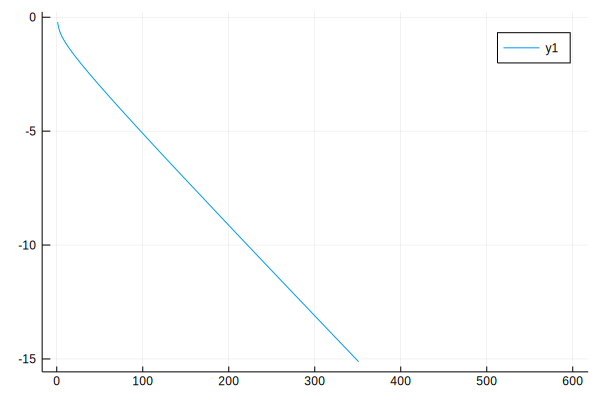

In [6]:
plot(log10.(abs.(G[1,1:end])))

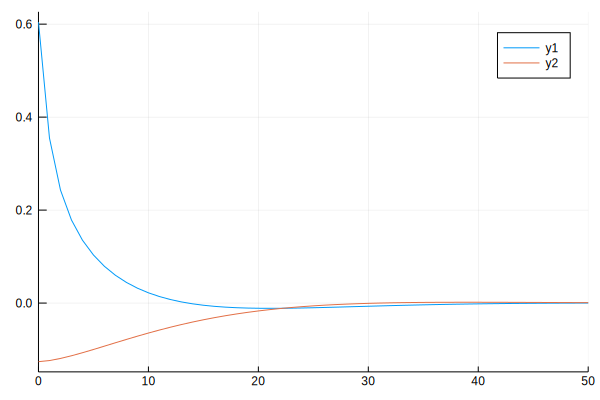

In [32]:
ir = 0:140
plot(ir,real.(Fields.lgf_helmholtz.(ir,0,0.016)),xlim=(0,50),markersize=3,markercolor=:blue)
plot!(ir,imag.(Fields.lgf_helmholtz.(ir,0,0.016)))

In [9]:
using SpecialFunctions

In [10]:
f1(i,j,α) = conj(im*0.25*hankelh1(0,exp(im*π/4)*sqrt(α)*sqrt(i^2+j^2)))

f1 (generic function with 1 method)

In [14]:
f2(i,j,α) = -im*0.25*hankelh2(0,exp(-im*π/4)*sqrt(α)*sqrt(i^2+j^2))

f2 (generic function with 1 method)

In [19]:
f2(148,10,0.016)

3.669524634875984e-8 - 7.026135332509448e-8im

In [ ]:
@time Fields.lgf_helmholtz(i,200,200)

In [4]:
# size
nx = 12; ny = 12
i = 5; j = 7
a = 2.0 + 5.0im
α = 0.07
#cellunit = Nodes(Dual,(nx,ny),dtype=Float64)
cellunitreal = Nodes(Dual,(nx,ny))
fill!(cellunitreal,2.0)
cellunit = Nodes(Dual,(nx,ny),dtype=ComplexF64)
cellunit[i,j] = a
cellunit[2,3] = 2*a
LH = Fields.plan_helmholtz(nx,ny,α;with_inverse=true)

Discrete Helmholtz operator (and inverse) on a (nx = 12, ny = 12) grid with spacing 1.0

In [34]:
cellunitconj = deepcopy(cellunit)
fill!(cellunitconj,a);

In [25]:
ψ = LH\cellunit
@time helmψ = LH*ψ
helmψ[i,j]

  0.062427 seconds (175.52 k allocations: 9.515 MiB)


1.9999999999999991 + 5.000000000000004im

In [62]:
pkg"test ViscousFlow"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %   Testing ViscousFlow
 Resolving package versions...
Test Summary: | Pass  Total
Grid Routines |   75     75
Test Summary:         | Pass  Total
Complex Grid Routines |   73     73
Test Summary: | Pass  Total
Fields        |   27     27
Test Summary:        | Pass  Total
Point-Field Routines |   56     56
Test Summary: | Pass  Total
Time Marching |    3      3
Test Summary:        | Pass  Total
Saddle-Point Systems |    9      9
Test Summary: | Pass  Total
Navier-Stokes |   27     27
   Testing ViscousFlow tests passed 


In [44]:
using Plots

In [24]:
Re = 40
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)
g = PhysicalGrid(xlim,ylim,Δx)

PhysicalGrid{2}((600, 600), (300, 300), 0.02, ((-5.98, 5.98), (-5.98, 5.98)))

In [25]:
α = Re*Δx^2

0.016

In [26]:
w1 = Nodes(Dual,size(g),dtype=ComplexF64)
q1 = Edges(Primal,w1,dtype=ComplexF64)
n = 150
body = Circle(1.0,n)
X = VectorData(collect(body))
f1 = VectorData(X,dtype=ComplexF64);
nx, ny = size(g)

(600, 600)

In [27]:
LH = Fields.plan_helmholtz(nx,ny,α;with_inverse=true)

┌ Info: Building and caching Helmholtz LGF table for α = 0.016
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:43
┌ Info: Switch to asymptotic formula at i = 148
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:47
┌ Info: Support radius = 351
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Discrete Helmholtz operator (and inverse) on a (nx = 600, ny = 600) grid with spacing 1.0

In [28]:
L = Fields.plan_laplacian(nx,ny;with_inverse=true,dtype=ComplexF64)

Discrete Laplacian (and inverse) on a (nx = 600, ny = 600) grid acting on Complex{Float64} data with spacing 1.0

In [29]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true)
H, E = RegularizationMatrix(regop,f1,q1)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [30]:
B₁ᵀ(f::VectorData{N,T}) where {N,T} = Curl()*(H*f)
B₂(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = -(E*(Curl()*(L\w)))
A⁻¹(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = LH\w

A⁻¹ (generic function with 1 method)

In [31]:
S1 = SaddleSystem((w1,f1),(A⁻¹,B₁ᵀ,B₂),issymmetric=true,store=true)

Saddle system with 300 constraints and
   State of type Nodes{Dual,600,600,Complex{Float64}}
   Force of type VectorData{150,Complex{Float64}}


In [32]:
rhs1 = deepcopy(f1)
fill!(rhs1.u,1.0)
fill!(rhs1.v,0.0)
rhs = (zero(w1),rhs1)
w1, f1 = S1\rhs
s1 = -(L\w1);

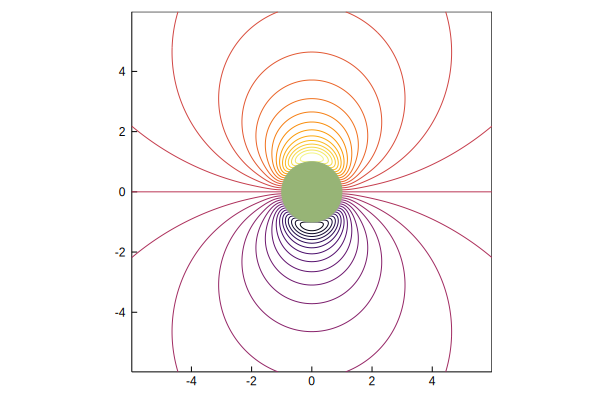

In [33]:
xg, yg = coordinates(w1,g)
plot(xg,yg,Δx*real(s1),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)

In [207]:
capprox(n) = (-1)^(n/2)*2*pi/gamma(1/4)^2/sqrt(n)

capprox (generic function with 1 method)

In [202]:
exp(-0.73832)

0.4779161405794755

In [209]:
capprox(20)

0.10688154436623562

In [215]:
ellipk(1/2)

1.854074677301372

In [214]:
abs(capprox(34)-c(34))

4.429495378002746e-6

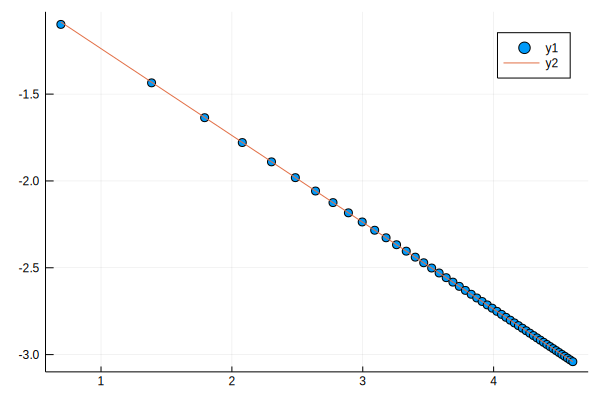

In [213]:
n = 2:2:100
scatter(log.(n),log.(abs.(c.(n))))
plot!(log.(n),log.(abs.(capprox.(n))))

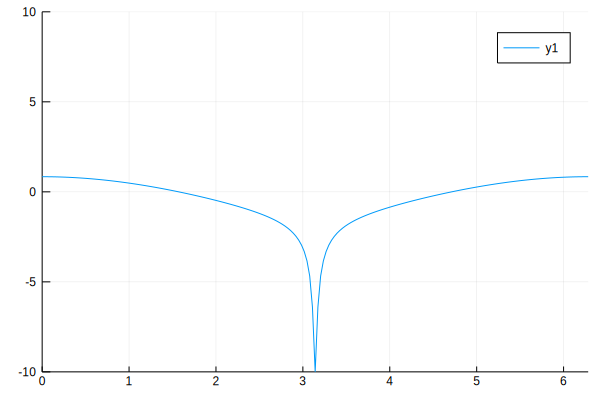

In [42]:
using Plots
t = range(0,2π,length=201)
plot(t,cos.(t).*f.(t,0.01),xlim=(0,2π),ylim=(-10,10))

In [16]:
w = Nodes(Dual,(6,6),dtype=ComplexF64)
w[4,3] = 1.0im
grad(w)
q = Edges(Dual,w)
interpolate!(q,w)

Edges{Dual,6,6,Complex{Float64}} data
u (in grid orientation)
6×5 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.5im  0.0+0.5im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
v (in grid orientation)
5×6 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.5im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.5im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [4]:
Re = 40
Δx = 0.02
α = Re*Δx^2

0.016

In [6]:
@time Fields.lgf_helmholtz(0,0,α)

  0.000803 seconds (2.22 k allocations: 739.859 KiB)


0.6046081337066918 - 0.12604993459635727im

Define the Helmholtz operator here

In [5]:
struct Helmholtz
    α :: Float64
end

In [18]:
(LH::Helmholtz)(f,i::Int,j::Int) = im*LH.α*f(i,j)-(f(i-1,j)+f(i+1,j)+f(i,j+1)+f(i,j-1)-4*f(i,j))

and the LGF of the Helmholtz operator

In [15]:
struct HelmholtzLGF
    α :: Float64
end
(G::HelmholtzLGF)(i::Int,j::Int) = Fields.lgf_helmholtz(i,j,G.α)

Set up the operator and its lattice Green's function

In [19]:
LH = Helmholtz(α)
G = HelmholtzLGF(α)

HelmholtzLGF(0.016)

Now we can evaluate this at any index. We should find that it is equal to 1 at 0,0 and equal to 0 at any other location.

In [21]:
LH(G,10,5)

1.6479873021779667e-17 + 6.323609171021705e-17im

In [3]:
struct MyType{M,N,P,T}
    data :: Array{T,1}
end

In [4]:
function MyType(M,NP::Tuple{Int,Int},T)
    return MyType{M,NP...,T}(zeros(T,M))
end

MyType

In [5]:
MyType(5,(5,6),ComplexF64)

MyType{5,5,6,Complex{Float64}}(Complex{Float64}[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])

In [34]:
Fields.load_lgf_helmholtz(100,α)

┌ Info: Building and caching Helmholtz LGF table for α = 0.016
└ @ ViscousFlow.Fields /Users/jeff/JuliaProjects/ViscousFlow/src/fields/lgf-helmholtz.jl:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


100×100 LinearAlgebra.Symmetric{Complex{Float64},Array{Complex{Float64},2}}:
    0.604608-0.12605im     …  -7.79917e-6-1.49118e-6im
    0.355112-0.123632im       -7.79613e-6-1.48694e-6im
    0.243216-0.119097im       -7.78702e-6-1.47422e-6im
    0.178728-0.11333im        -7.77183e-6-1.4531e-6im 
    0.135291-0.106797im       -7.75055e-6-1.42368e-6im
    0.103446-0.0998128im   …  -7.72317e-6-1.38611e-6im
   0.0790089-0.0926061im      -7.68967e-6-1.34059e-6im
   0.0597712-0.0853494im      -7.65004e-6-1.28735e-6im
   0.0444092-0.0781732im      -7.60427e-6-1.22665e-6im
   0.0320514-0.0711767im      -7.55234e-6-1.15881e-6im
   0.0220851-0.0644339im   …  -7.49423e-6-1.08418e-6im
   0.0140571-0.0579992im      -7.42995e-6-1.00313e-6im
  0.00761958-0.0519106im       -7.3595e-6-9.16073e-7im
            ⋮              ⋱                          
 -8.72654e-6-2.07633e-5im      3.26589e-7+1.12903e-7im
 -9.59028e-6-1.80959e-5im      3.12701e-7+8.76258e-8im
 -1.01564e-5-1.56109e-5im  …   2.98169e-7+6

In [8]:
using Plots

In [9]:
quadgleg(f::Function) = dot(Fields.GLH_WEIGHTS_10000, f(Fields.GLH_NODES_10000))

quadgleg (generic function with 1 method)

In [10]:
pkg"add Cubature"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
 Installed Cubature ─ v1.4.1
  Updating `~/JuliaProjects/ViscousFlow/Project.toml`
  [667455a9] + Cubature v1.4.1
  Updating `~/JuliaProjects/ViscousFlow/Manifest.toml`
  [667455a9] + Cubature v1.4.1
  Building Cubature → `~/.julia/packages/Cubature/GQTey/deps/build.log`


In [113]:
f(i,j,x,α) = exp.(im*α*x/4).*besseli.(i,x/2).*besseli.(j,x/2)

f (generic function with 1 method)

In [16]:
using SpecialFunctions
using LinearAlgebra

In [204]:
# in bessel form
#Tmax = 10000.0
#nseg = 1
#tseg = 0:Tmax/nseg:Tmax
function lgfhI(i, j, α)
    #if i == j ==0
    #    return 0.0
    if i ≥ j
        v = ComplexF64(0)
        #for idex in 1:length(tseg)-1            
            v += quadgleg() do x
                #a = (tseg[idex+1]-tseg[idex])/2
                #b = (tseg[idex+1]+tseg[idex])/2                
                #t = a*x .+ b   
                t = 1.0 .+ 2.0*x ./ (1 .- x)
                dtdx = 2.0 ./ (1 .- x).^2
                return dtdx.*besselix.(i,2*t).*besselix.(j,2*t).*exp.(-im*α*t)
            end
        #end
        return v
    else
        return lgfhI(j,i,α)
    end

end

lgfhI (generic function with 1 method)

In [205]:
LH(0,0,lgfhI,α)

1.001989093963061 - 0.0043994263944577335im

In [206]:
lgfhI(0,0,α)

0.32969320807084046 - 0.25036815074409025im

In [11]:
t(x) = 1.0 .+ 2.0*x ./ (1 .- x)
f(x,i,j,α) = (t1 = t(x); dtdx = 2.0 ./ (1 .- x).^2; return dtdx .* exp.(-im*α*t1).*besselix.(i,2*t1).*besselix.(j,2*t1))

f (generic function with 1 method)

In [14]:
using Cubature

┌ Info: Precompiling Cubature [667455a9-e2ce-5579-9412-b964f529a492]
└ @ Base loading.jl:1242


In [18]:
(val,err) = hquadrature(x -> real.(f(x,0,0,α)), -1, 1;
                        reltol=1e-8, abstol=0, maxevals=0)

SpecialFunctions.AmosException: AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.

In [193]:
forig(t,i,j,α) = exp.(-im*α*t).*besselix.(i,2*t).*besselix.(j,2*t)

forig (generic function with 1 method)

In [172]:
2.0 ./ (1 .- x).^2

1.2615662605369927e-5

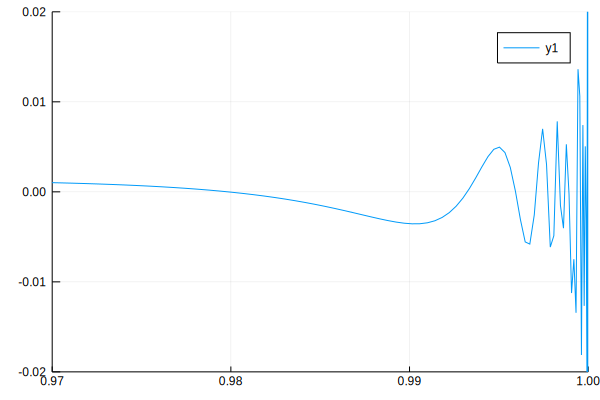

In [222]:
plot(Fields.GLH_NODES_1000,Fields.GLH_WEIGHTS_1000.*real.(f.(Fields.GLH_NODES_1000,0,1,α)),ylim=(-0.02,0.02),xlim=(0.97,1))

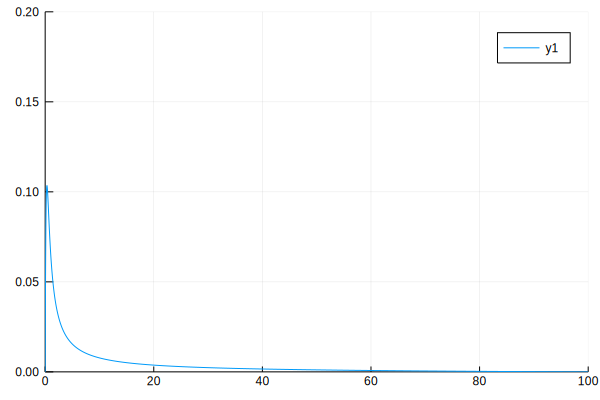

In [198]:
t_array = range(0,100,length=10000)
plot(t_array,real.(forig.(t_array,0,1,α)),ylim=(0,0.2),xlim=(0,100))

In [888]:
@time lgfhI(1,0,α)

  0.000747 seconds (40 allocations: 95.547 KiB)


0.355224488682314 - 0.12411601441207876im

In [897]:
alpha_to_string(α::Float64) = string(100000+α*10000)[2:6]
"lgfhtable_alpha"*alpha_to_string(α)*".dat"

"lgfhtable_alpha00160.dat"

In [898]:
const LGFH_DIR  = joinpath(pwd(), "cache")

"/Users/jeff/JuliaProjects/ViscousFlow/examples/cache"

In [776]:
# in dft form
function lgfh2(i, j, α)
    #if i == j ==0
    #    return 1/(im*α)
    if i ≥ j
        v = ComplexF64(0.0)
        for (idex,y) in enumerate(GL_NODES)
            xi1 = 0.5*π*(y+1) 
            expixi1 = cos(i*xi1)
            cosxi1 = cos(xi1)
            v += GL_WEIGHTS[idex]*quadgleg() do x
                xi2 = 0.5*π*(x .+ 1)            
                expixi2 = cos.(j*xi2)
                return expixi2.*expixi1./(im*α .+ 4 .- 2*cos.(xi2) .- 2*cosxi1)
            end
        end
        return v/4
    else
        return lgfh2(j,i,α)
    end

end

lgfh2 (generic function with 1 method)

In [565]:
i = 1
xiiseg = 0:π/max(1,abs(i)):π
xiiseg[2]

3.141592653589793

In [741]:
i = 10
max(1,ceil(abs(i/2)))

5.0

In [753]:
# in dft form
function lgfh2seg(i, j, α)
    #if i == j ==0
    #    return 1/(im*α)
    if i ≥ j
        v = ComplexF64(0.0)
        xiiseg = 0:π/max(1,ceil(abs(i))):π
        xijseg = 0:π/max(1,ceil(abs(j))):π
        for iseg = 1:length(xiiseg)-1
            ai = (xiiseg[iseg+1]-xiiseg[iseg])/2
            bi = (xiiseg[iseg+1]+xiiseg[iseg])/2 
            for (idex,y) in enumerate(GL_NODES)
                wti = GL_WEIGHTS[idex]
                xi1 = ai*y + bi 
                expixi1 = cos(i*xi1)
                #println(expixi1)
                cosxi1 = cos(xi1)
                for jseg = 1:length(xijseg)-1
                    aj = (xijseg[jseg+1]-xijseg[jseg])/2
                    bj = (xijseg[jseg+1]+xijseg[jseg])/2
                    v += aj*ai*wti*quadgleg() do x    
                        xi2 = aj*x .+ bj
                        expixi2 = cos.(j*xi2)
                        return expixi2.*expixi1./(im*α .+ 4 .- 2*cos.(xi2) .- 2*cosxi1)
                    end
                end    
            end
        end
        return v/π^2
    else
        return lgfh2seg(j,i,α)
    end

end

lgfh2seg (generic function with 1 method)

In [136]:
pkg"test ViscousFlow"

   Testing ViscousFlow
 Resolving package versions...
Test Summary: | Pass  Total
Grid Routines |   75     75
Test Summary: | Pass  Total
Fields        |   27     27
Test Summary:        | Pass  Total
Point-Field Routines |   51     51
Test Summary: | Pass  Total
Time Marching |    3      3
Test Summary:        | Pass  Total
Saddle-Point Systems |    9      9
Test Summary: | Pass  Total
Navier-Stokes |   27     27
   Testing ViscousFlow tests passed 


In [23]:
@time LH(5,10,Fields.lgf_helmholtz,α)

  0.000810 seconds (4.60 k allocations: 442.125 KiB)


-0.00020816660635519834 + 0.0002333875076078649im

In [24]:
α

0.016

In [850]:
@time lgfhI(2,2,α)

  0.023491 seconds (7.00 k allocations: 4.038 MiB)


0.184231926595667 - 0.11479839248060304im

In [793]:
i = 0:100; j = 0:100
lgfh_array = zeros(ComplexF64,length(i),length(j))
for i1 in i, j1 in j
    lgfh_array[i1+1,j1+1] = lgfh2(i1,j1,α)
end

In [780]:
i = 0:100; j = 0:100
lgfherr_array = zeros(ComplexF64,length(i),length(j))
for i1 in i, j1 in j
    lgfherr_array[i1+1,j1+1] = abs(LH(i1,j1,lgfh2,α))
end

In [439]:
i = 0:100; j = 0:100
lgf_array = zeros(ComplexF64,length(i),length(j))
for i1 in i, j1 in j
    lgf_array[i1+1,j1+1] = lgfh2(i1,j1,0)
end

In [787]:
maximum(real.(lgfherr_array[2:end,2:end]))

1.3239041031387797e-15

In [12]:
using Plots

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


In [46]:
lgfasymp(i,j,α) = im*0.25*sqrt(2*exp(im*π/4)/π/sqrt(α)/sqrt(i^2+j^2))*exp(-im*π/4)*exp(exp(-im*3*π/4)*sqrt(α)*sqrt(i^2+j^2))

lgfasymp (generic function with 1 method)

In [61]:
using SpecialFunctions

In [121]:
?hankelh2

search: hankelh2 hankelh2x hankelh1 hankelh1x



```
hankelh2(nu, x)
```

Bessel function of the third kind of order `nu`, $H^{(2)}_\nu(x)$.


In [133]:
lgfasymp2(i,j,α) = conj(im*0.25*hankelh1(0,exp(im*π/4)*sqrt(α)*sqrt(i^2+j^2)))

lgfasymp2 (generic function with 1 method)

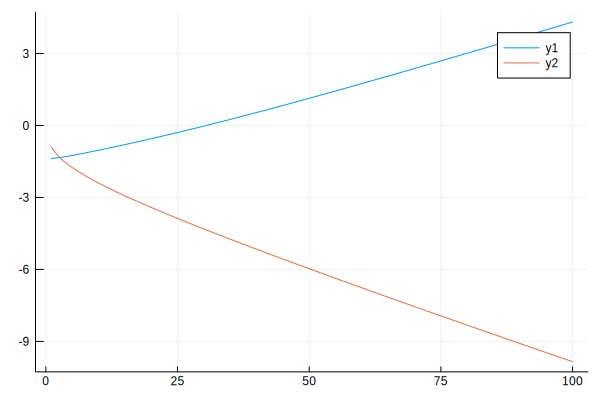

In [125]:
α = 0.01
i = 1:100
plot(i,log.(abs.(Fields.lgf_helmholtz.(i,0,α)-lgfasymp2.(i,0,α))))
plot!(i,log.(abs.(Fields.lgf_helmholtz.(i,0,α))))
#plot!(i,log.(abs.(0.08*exp.(-2π*0.12*sqrt(α)*sqrt.(i.^2 .+ 0^2)))))
#plot!(i,log.(abs.(lgfasymp2.(i,0,α))))
#plot!(i,log.(abs.(lgfasymp.(i,0,α))))

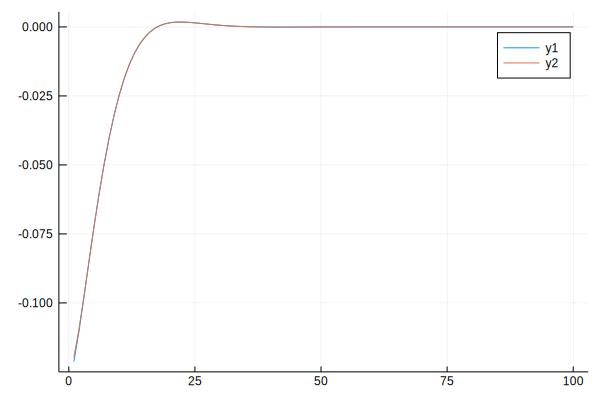

In [137]:
α = 0.05
i = 1:100
plot(i,imag.(Fields.lgf_helmholtz.(i,0,α)))
plot!(i,imag.(lgfasymp2.(i,0,α)))

In [145]:
α = 0.016
i = 1
j = 0
while abs.(Fields.lgf_helmholtz.(i,j,α)-lgfasymp2.(i,j,α)) > 1e-9
    i += 1
end
println(i)

148


In [830]:
i=1; j = 1
f(t) = exp(-im*α*t)*besselix(i,2*t)*besselix(j,2*t)

f (generic function with 2 methods)

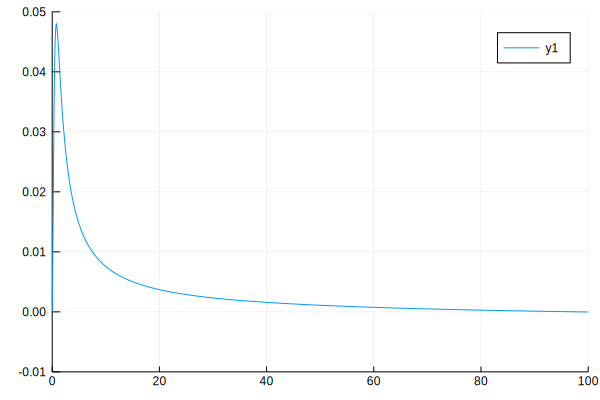

In [839]:
t = range(0,100,length=1001)
plot(t,real.(f.(t)),xlim=(0,100),ylim=(-0.01,0.05))

In [1]:
abstract type CellType end
abstract type Primal <: CellType end
abstract type Dual <: CellType end

abstract type GridData{NX,NY} <: AbstractMatrix{Float64} end

abstract type ScalarGridData{NX,NY} <: GridData{NX,NY} end

abstract type VectorGridData{NX,NY} <: GridData{NX,NY} end

xedge_inds(::Type{Dual}, dualnodedims) = (dualnodedims[1]-1, dualnodedims[2])
yedge_inds(::Type{Dual}, dualnodedims) = (dualnodedims[1], dualnodedims[2]-1)

xedge_inds(::Type{Primal}, dualnodedims) = (dualnodedims[1], dualnodedims[2]-1)
yedge_inds(::Type{Primal}, dualnodedims) = (dualnodedims[1]-1, dualnodedims[2])

yedge_inds (generic function with 2 methods)

In [2]:
struct XEdges{C <: CellType, NX, NY, T <: Number} #<: ScalarGridData{NX,NY}
    data::Matrix{T}
end

In [9]:
function XEdges(T::Type{C}, dualnodedims::Tuple{Int, Int};dtype=Float64) where {C <: CellType}
    dims = xedge_inds(T, dualnodedims)
    XEdges{T, dualnodedims...,dtype}(zeros(dtype,dims))
end

XEdges

In [10]:
q = XEdges(Dual,(5,5),dtype=ComplexF64)

XEdges{Dual,5,5,Complex{Float64}}(Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im])

In [11]:
q

XEdges{Dual,5,5,Complex{Float64}}(Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im])

In [15]:
typeof(zeros(Float64,5)) <: AbstractArray{ComplexF64}

false